In [97]:
from utils.testproblems import generate_random_prob
from utils.polycasebuilder import generate_random_polynomials
from graph.graphutils import edges_to_Ein_Eout, sources, all_edges, all_variables, flat_graph_formulation
from graph.operators import invert_edges, eqv_to_edges_tree, sort_scc
from graph.matrixview import render_incidence
from presolver.tearing import dir_graph, min_arc_set_assign, min_arc_set
from trash.inputresolver import reassigneq
from collections import OrderedDict
import torch
import sympy as sp

In [98]:
n_eqs, n_vars, sparsity, seed1, seed2 = 10, 15, 1.2, 42, 12345 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed1, sparsity)
polynomials, var_mapping, edges, tree = generate_random_polynomials(eqv, dout, n_eqs, seed=seed2)
symb_mapping = {key: elt[0] for key, elt in var_mapping.items()}
inputids = sorted(sources(*edges_to_Ein_Eout(edges)))
inputvars = [var_mapping[elt][0] for elt in inputids]
fobj = sum([(elt-1)**2 for elt in inputvars])

In [99]:
edges_for_solving = invert_edges(eqv)
eqnidxs = list(eqv.keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)

In [100]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, [], [])
outset_opt = {right:left for left, right in edges_left_right 
            if (left,right) in edges_left_right and xsol[left, right] > 0.5}

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07


In [101]:
edgesopt, _, _ = eqv_to_edges_tree(eqv, output_set=outset_opt)
G = flat_graph_formulation(*edgesopt)
order = sort_scc(G)
treeopt = (OrderedDict([(elt.pop().name,1) for elt in order]),{},{})

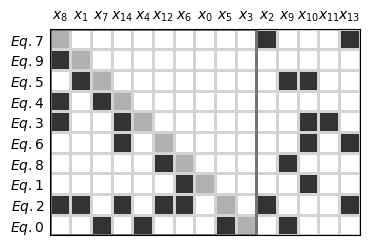

In [102]:
render_incidence(edgesopt, treeopt, rotation=0, hideticks=True, dispendcomp=True, figsize=((4,4)), fontsize=10);

## Let's run it

In [103]:
from torchengine import AnalyticalSet, EliminateAnalysis, Function, EliminateAnalysisMergeResiduals
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{:0.2f}".format(x).rstrip('0').rstrip('.')})

In [104]:
indices = {idx: torch.tensor([idx]) for idx in range(n_vars)}
sets = {}
edges = edgesopt
for polyidx, poly in polynomials.items():
    outputvar = symb_mapping[edges[1][polyidx][0]]
    inputvars = [symb_mapping[elt] for elt in edges[0][polyidx]]
    analysis_function = sp.simplify(reassigneq(None, poly, outputvar))
    if isinstance(analysis_function, sp.Float):
        tensor = torch.tensor([float(analysis_function)], dtype=torch.float64)
        f = lambda : tensor
    else:
        f = sp.lambdify(inputvars, analysis_function, torch) 
    residual = sp.lambdify(inputvars+[outputvar], poly, torch)   
    tupl = (edges[0][polyidx]+edges[1][polyidx], residual)
    triplet = (edges[0][polyidx], edges[1][polyidx], f)
    sets[polyidx] = AnalyticalSet(triplet, indices, forceresidual=tupl)

In [195]:
execution_order = list(treeopt[0].keys())
feed_forward = EliminateAnalysis([sets[k].analysis for k in execution_order],[])

In [196]:
torch.manual_seed(43)
x0 = torch.rand(n_vars, dtype=torch.float64)
xout = feed_forward(x0)

In [198]:
xout.numpy()

array([41.73, 0.35, 0.18, 0.33, -7.27, -0.04, 0.02, -10.92, -6.49, 0.72,
       0.86, 0.59, 26.98, 0.5, -0.06])

# Load from file

In [2]:
import json
from sympy import sympify
from itertools import chain
import torch
import re

def extract_number(string):
    return int(re.search(r'\d+', string).group())

def process_json(data):
    functional_sets = data["functional_sets"]
    objective = data['objective']
    
    objective_sympy = None
    polynomials = {}
    symb_mapping = {}
    symb_str_mapping = {}
    edges = (dict(),dict())
    
    functional_set_info = ((functional_set['residual'], functional_set['functionalvar']) 
                           for functional_set in functional_sets)

    for idx, functional_set in chain(enumerate(functional_set_info), [('objective', [objective, None])]) :
        function_str, output_var_str = functional_set
        function = sympify(function_str, locals=symb_str_mapping)
        if idx == 'objective':
            objective_sympy = function
        else:
            polynomials[idx] = function
        
        input_vars, output_var = tuple(), tuple()
        for symbol in function.free_symbols:
            if str(symbol) not in symb_str_mapping:
                symb_str_mapping[str(symbol)] = symbol
            if str(symbol) == output_var_str:
                symb_mapping[idx] = symb_str_mapping[str(symbol)]
                output_var = (symbol,)
            else:
                input_vars += (symbol,)

        if idx != 'objective':
            edges[0][idx] = input_vars
            edges[1][idx] = output_var

    indices = {elt: torch.tensor([int(i)]) for i, elt in 
               enumerate(sorted(symb_str_mapping.values(), key=lambda item: extract_number(str(item))))}

    return polynomials, indices, edges, objective_sympy

In [3]:
# check if file exists or not return True/False
import os
file_path = '../applications/data/testproblems.json'
os.path.isfile(file_path)
# load file
with open(file_path, 'r') as file:
    json_str = file.read()

In [4]:
data = json.loads(json_str)

In [5]:
fid, fdata = list(data.items())[0]

In [6]:
from torchengine import AnalyticalSetSympy

In [7]:
polynomials, indices, edges, objective = process_json(fdata)

In [8]:
from graph.graphutils import edges_to_Ein_Eout, sources, all_edges, all_variables, flat_graph_formulation
from graph.operators import invert_edges, sort_scc, eqv_to_edges_tree
from presolver.tearing import dir_graph, min_arc_set_assign, min_arc_set

In [9]:
G = flat_graph_formulation(edges[0], edges[1], {})
order = sort_scc(G)

### Changing inputs and outputs

In [10]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, [], [])
outset_opt = {right:left for left, right in edges_left_right 
            if (left,right) in edges_left_right and xsol[left, right] > 0.5}

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07


In [11]:
outset_opt

{0: x_7,
 1: x_12,
 2: x_9,
 3: x_5,
 4: x_8,
 5: x_1,
 6: x_10,
 7: x_2,
 8: x_13,
 9: x_14}

In [12]:
edgesopt, _, _ = eqv_to_edges_tree(edges_for_solving[0], output_set=outset_opt)
Gopt = flat_graph_formulation(*edgesopt)
order_opt = sort_scc(Gopt)

In [13]:
order

[{f_7}, {f_3}, {f_0, f_5, f_6, f_8, f_9}, {f_2}, {f_1}, {f_4}]

In [14]:
order_opt

[{f_7}, {f_9}, {f_2}, {f_5}, {f_6}, {f_0}, {f_4}, {f_8}, {f_1}, {f_3}]

In [19]:
sets = {idx:AnalyticalSetSympy(poly, indices=indices).reassign(edges[1][idx][0],  rational=True) for idx,poly in polynomials.items()}

In [16]:
sets_opt = {idx:AnalyticalSetSympy(poly, indices=indices).reassign(outset_opt.get(idx, None), rational=True) for idx,poly in polynomials.items()}

In [20]:
functional_sets = []
for idx, fset in sets.items():
    functional_sets.append(
        {'residual':str(fset.sympyresidual),
         'analysis': str(fset.expression), 
        'functionalvar': str(fset.outputvar)})
output = {'functional_sets':functional_sets, 
            'equality_constraints': [], # need to assign as a function of the order/sort scc
            'inequality_constraints':[], 
            'objective': str(objective)}
output

{'functional_sets': [{'residual': '-1.0*x_10*x_7 + 0.6*x_11 + 0.8',
   'analysis': '5*x_10*x_7/3 - 4/3',
   'functionalvar': 'x_11'},
  {'residual': '0.1*x_12*x_3*x_8 + 0.9*x_6 + 0.6',
   'analysis': '3*(-3*x_6 - 2)/(x_12*x_3)',
   'functionalvar': 'x_8'},
  {'residual': '0.5*x_0 - 0.9*x_11*x_6*x_9 - 0.6',
   'analysis': '(5*x_0 - 6)/(9*x_11*x_9)',
   'functionalvar': 'x_6'},
  {'residual': '-0.4*x_0*x_5 - 0.2*x_13 - 0.9',
   'analysis': '-2*x_0*x_5 - 9/2',
   'functionalvar': 'x_13'},
  {'residual': '0.3*x_10*x_4 + 0.3*x_8 + 0.2',
   'analysis': '(-x_8 - 2/3)/x_10',
   'functionalvar': 'x_4'},
  {'residual': '0.4*x_1*x_3*x_9 + 0.3*x_11*x_14 + 0.4',
   'analysis': '4*(-x_1*x_3*x_9 - 1)/(3*x_11)',
   'functionalvar': 'x_14'},
  {'residual': '-0.7*x_10*x_9 + 0.4',
   'analysis': '4/(7*x_10)',
   'functionalvar': 'x_9'},
  {'residual': '0.1*x_2 - 0.4', 'analysis': '4', 'functionalvar': 'x_2'},
  {'residual': '0.8*x_10*x_13 + 0.9*x_3 - 0.3',
   'analysis': '3*(1 - 3*x_3)/(8*x_13)',
   'fun

In [21]:
# # save json data
# import json
# with open('../applications/data/prob2.json', 'w') as f:
#     json.dump(output, f, indent=4)